In [21]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [22]:
# Load the Dataset
df = pd.read_csv('C:/Users/HP/Documents/heartdisease/dataset.csv')
print("Data loaded successfully.")

Data loaded successfully.


In [23]:
# Displaying the rows and column names
print("Printing First 5 rows of the dataset:")
print(df.head())
print("-" * 30)
print("\nDataFrame Columns:")
print(df.columns.tolist())
print("-" * 30)
print("\nDataset Information:")
df.info()

Printing First 5 rows of the dataset:
   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0  
-------------------

In [24]:
# Exploratory Data Analysis (EDA) with Plots
plt.style.use('ggplot')

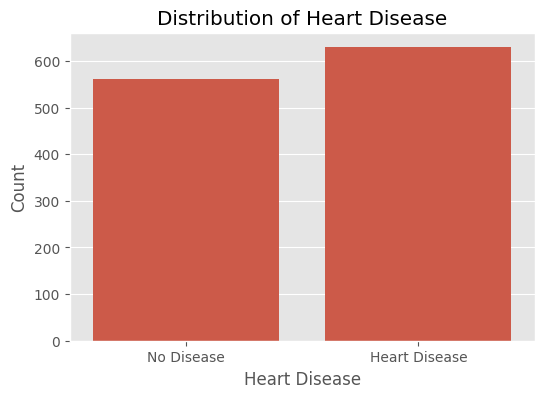

In [25]:
# Plot 1: checking heart disease
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Heart Disease')
plt.xticks([0, 1], ['No Disease', 'Heart Disease'])
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()

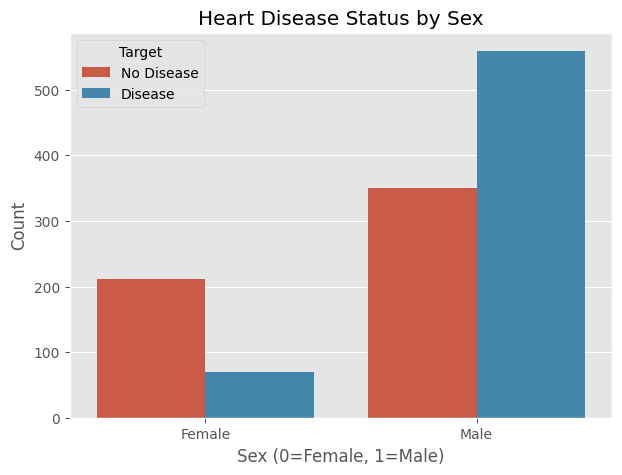

In [26]:
# Plot 2: Heart Disease based on Sex
plt.figure(figsize=(7, 5))
sns.countplot(x='sex', hue='target', data=df)
plt.title('Heart Disease Status by Sex')
plt.xticks([0, 1], ['Female', 'Male'])
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('Count')
plt.legend(title='Target', labels=['No Disease', 'Disease'])
plt.show()

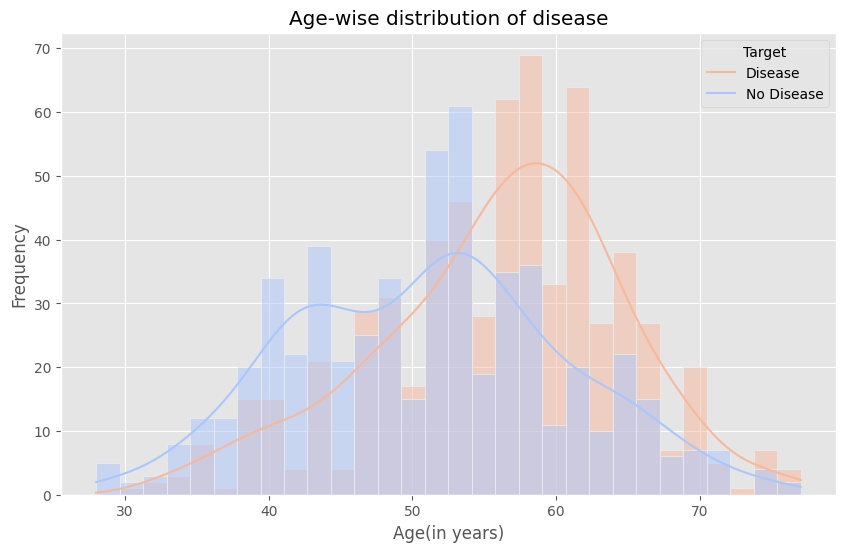

In [27]:
# Plot 3: heart disease based on Age criteria 
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='target', bins=30, kde=True, palette='coolwarm')
plt.title('Age-wise distribution of disease')
plt.xlabel('Age(in years)')
plt.ylabel('Frequency')
plt.legend(title='Target', labels=['Disease', 'No Disease'])
plt.show()

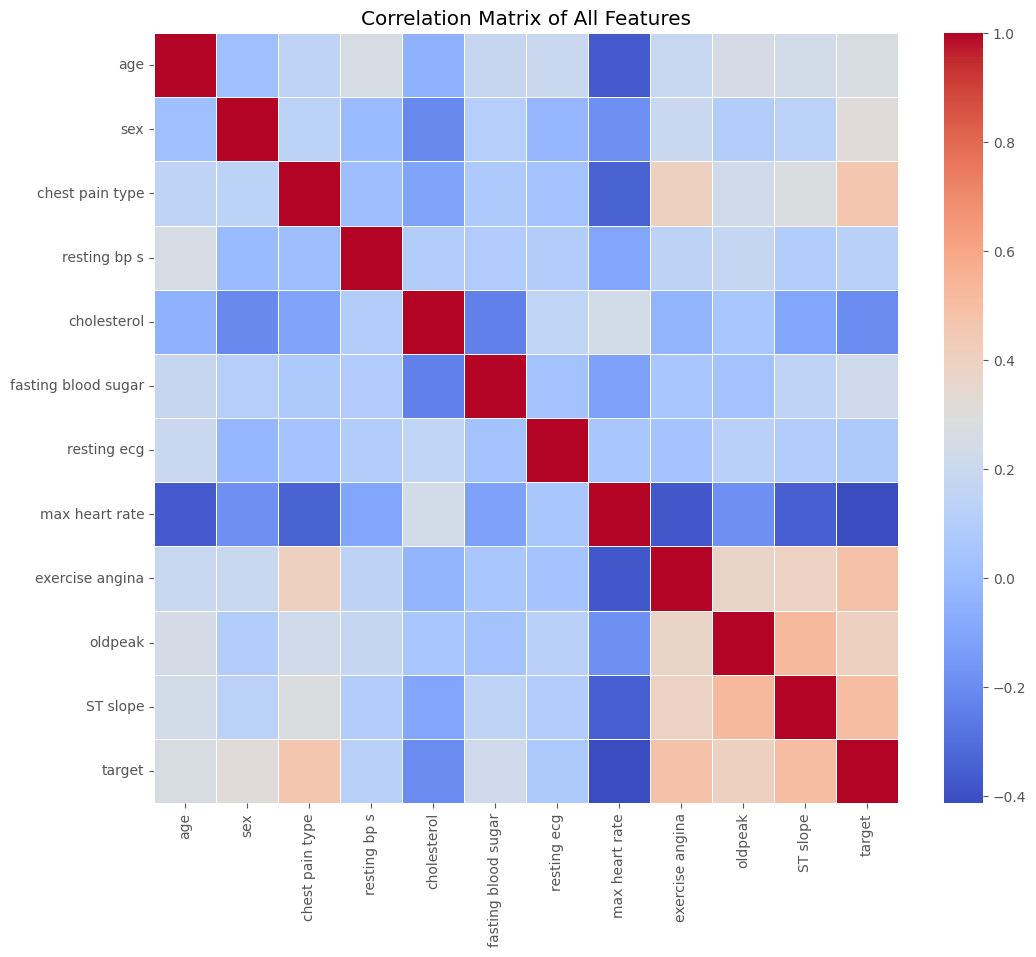

In [28]:
## Plot 4: Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df.corr(numeric_only=True) 
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of All Features')
plt.show()

In [29]:
# Data Preprocessing 
TARGET_COL = 'target'
NUMERIC_COLS = [
    'age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak'
]
BINARY_COLS = [
    'sex', 'fasting blood sugar', 'exercise angina'
]
NOMINAL_COLS = [
    'chest pain type', 'resting ecg', 'ST slope'
]

In [30]:
# Separate features (X) and target (y)
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

In [31]:
# preprocessing steps
numeric_transformer = StandardScaler()
nominal_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [32]:
# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_COLS),
        ('nom', nominal_transformer, NOMINAL_COLS),
        ('bin', 'passthrough', BINARY_COLS) 
    ],
    remainder='drop' 
)

In [33]:
# Model Training and Evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("-" * 30)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])
print("\nTraining the Model...")
model.fit(X_train, y_train)

------------------------------

Training the Model...


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
# Model Evaluation
y_pred = model.predict(X_test)
print("\n--Model Evaluation(By Logistic Regression)--")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['No Disease', 'Heart Disease']))


--Model Evaluation(By Logistic Regression)--
Classification Report:
                precision    recall  f1-score   support

   No Disease       0.87      0.84      0.85       168
Heart Disease       0.86      0.88      0.87       189

     accuracy                           0.86       357
    macro avg       0.86      0.86      0.86       357
 weighted avg       0.86      0.86      0.86       357



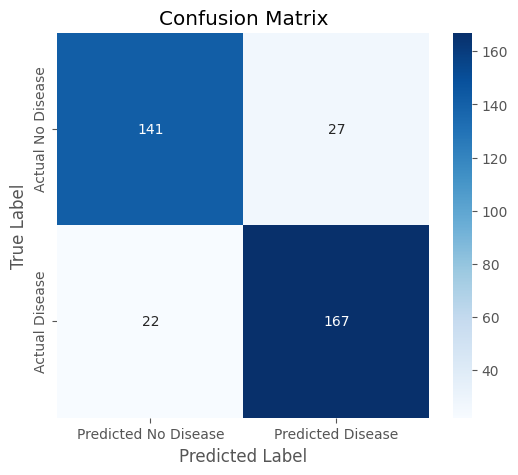

In [35]:
# Confusion Matrix Plot to check the actual predicted disease
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Disease', 'Predicted Disease'], 
            yticklabels=['Actual No Disease', 'Actual Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
# Prediction on New Patient Data
print("-" * 30)
print("Prediction on the New Patient Data")
new_patient_data = {
    'age': [62],                                
    'sex': [0],                                 
    'chest pain type': [4],                     
    'resting bp s': [150],                      
    'cholesterol': [245],                       
    'fasting blood sugar': [1],                
    'resting ecg': [0],                         
    'max heart rate': [120],                   
    'exercise angina': [1],                     
    'oldpeak': [3.5],                           
    'ST slope': [2]                             
}
X_new = pd.DataFrame(new_patient_data)
X_new = X_new[X.columns] 

------------------------------
Prediction on the New Patient Data


In [37]:
print(X_new.to_string(index=False))
new_prediction = model.predict(X_new)
probability = model.predict_proba(X_new)[0]
predicted_class = new_prediction[0]
predicted_prob = probability[predicted_class]

 age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  resting ecg  max heart rate  exercise angina  oldpeak  ST slope
  62    0                4           150          245                    1            0             120                1      3.5         2


In [38]:
result_map = {
    0: "Patient is fit and fine and No Heart Disease", 
    1: "Patient has a Heart Disease and needs treatment!"
}
print("-" * 30)
print(f"\nModel Prediction: {result_map[predicted_class]} (prediction ={predicted_class})")
print(f"Accuracy: {predicted_prob:.4f}")

------------------------------

Model Prediction: Patient has a Heart Disease and needs treatment! (prediction =1)
Accuracy: 0.9672


In [39]:
# LOGIC TO EXPLAIN THE PREDICTION WITH TARGETED REASONS
if predicted_class == 1:
    print("\n--Reason for Mark it Heart Disease--")
    lr_model = model.named_steps['classifier']
    preprocessor_fit = model.named_steps['preprocessor']
    
    # Get feature names 
    nominal_feature_names = list(preprocessor_fit.named_transformers_['nom'].get_feature_names_out(NOMINAL_COLS))
    all_feature_names = (NUMERIC_COLS + nominal_feature_names + BINARY_COLS)
    
    # Create a DataFrame of feature names and their coefficients
    coefficients_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Coefficient': lr_model.coef_[0]
    })


--Reason for Mark it Heart Disease--


In [40]:
# Based on 4 reasons: Blood pressure, sugar level(0 for ok,1 for high), heart rate, chest pain type
    # 1) Blood pressure
    bp_val = X_new['resting bp s'].iloc[0]
    bp_coef = coefficients_df[coefficients_df['Feature'] == 'resting bp s']['Coefficient'].iloc[0]
    
    if bp_val >= 140:
        print(f"Blood Pressure ({bp_val} mmHg): This level is considered Hypertensive (Stage 2), exceeding the normal limit of 120/80 mmHg (Weight: {bp_coef:.3f}).")
    elif bp_val >= 130:
        print(f" Blood Pressure ({bp_val} mmHg): This is in the Hypertensive (Stage 1) range, it increases long-term risk")
    else:
        print(f" Blood Pressure ({bp_val} mmHg): This value is within the acceptable range.")


    # 2) Blood Sugar range
    sugar_val = X_new['fasting blood sugar'].iloc[0] # 0 or 1
    sugar_coef = coefficients_df[coefficients_df['Feature'] == 'fasting blood sugar']['Coefficient'].iloc[0]
    
    if sugar_val == 1:
        print(f"Fasting Blood Sugar ({sugar_val}): The patient's sugar level is above the critical limit (> 120 mg/dl). High blood sugar is a powerful indicator of increased cardiovascular risk!")
    else:
        print(f"Fasting Blood Sugar ({sugar_val}): The patient's sugar level is within the normal limit (120 mg/dl).")


    # 3) Maximum Heart Rate Achieved
    hr_val = X_new['max heart rate'].iloc[0]
    hr_coef = coefficients_df[coefficients_df['Feature'] == 'max heart rate']['Coefficient'].iloc[0]
    
    # Note: A negative coefficient for max heart rate means that *higher* heart rate is associated with *lower* disease risk.
    # Therefore, a low patient value (like 120) increases the risk when the coefficient is negative.
    if hr_coef < 0:
        print(f"Max Heart Rate Achieved ({hr_val} bpm): This rate is low/moderate for peak exercise. A lower peak heart rate often indicates reduced functional capacity of the heart)(Weight: {hr_coef:.3f}).")
    else:
        print(f"Max Heart Rate Achieved ({hr_val} bpm): This rate is an high value, doing exercise regularly keep strong the heart which typically reduces the risk profile!")


    # 4) Chest Pain Type
    cp_code = X_new['chest pain type'].iloc[0]
    cp_map = {
        1: 'Typical Angina', 2: 'Atypical Angina', 
        3: 'Non-anginal Pain', 4: 'Asymptomatic'
    }
    cp_desc = cp_map.get(cp_code, 'Unknown')
    
    ohe_col = f'chest pain type_{cp_code}'
    if ohe_col in coefficients_df['Feature'].values:
        coef = coefficients_df[coefficients_df['Feature'] == ohe_col]['Coefficient'].iloc[0]
        
        if coef > 0 and cp_code == 4:
            print(f"Chest Pain Type: {cp_desc}: The most frequent type of chest pain in patients with severe disease is often Asymptomatic. This pattern is a significant risk factor")
        elif coef > 0 and cp_code in [1, 2]:
            print(f"Chest Pain Type: {cp_desc}: The presence of Angina chest pain is a direct symptom of reduced blood flow to the heart.")
        else:
            print(f"Chest Pain Type: {cp_desc}: This specific type of pain does not contribute significantly to the heart.")

IndentationError: unexpected indent (183576454.py, line 3)